In [1]:
# This notebook contains the core simulation structure for a 2D low Earth orbit communications network,
# but leaves key functions for you to implement. The goal is to guide you through the mathematics and
# algorithms while you learn by doing.
#
# How to use
# ----------
# - Open this file as a Jupyter Notebook.
# - Work cell by cell. Read the instructions in each markdown cell first.
# - Implement the functions marked with `NASIA TODO` and run the tests.
# - If a test fails, read the hint and try again. Ask/email me if you get stuck.
#
# After completing the scaffold, you will have (i) built a visibility-based connectivity graph,
# (ii) implemented Dijkstra for shortest path distance, (iii) animated the signal transmission.

In [2]:
import math
from dataclasses import dataclass
from typing import Tuple, List, Dict, Optional
import heapq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [6]:
# First, we define some constants, and the `Node` data structure.
# Each node will represent 1 satellite in orbit or 1 ground station.

In [3]:
R_EARTH_KM = 6371.0  # Earth radius in kilometres
C_KM_S = 299792.458  # Speed of light in km/s

@dataclass
class Node:
    id: str
    pos: Tuple[float, float]
    type: str  # 'sat' or 'ground'

In [8]:
# Nasia to-do list:
# -----------------
# Implement the following small geometry functions. They are used by the rest of the simulation.
# Each function has a short test below it to help you verify correctness.

# NASIA TODO: implement these functions

In [4]:
def polar_to_cartesian(radius_km: float, angle_rad: float) -> Tuple[float, float]:
    """Convert polar coordinates (radius, angle) to Cartesian (x, y)."""
    x = radius_km * math.cos(angle_rad)
    y = radius_km * math.sin(angle_rad)
    return (x, y)


# Quick test for polar_to_cartesian

try:
    # angle 0 -> point on +x axis
    assert polar_to_cartesian(1.0, 0.0) == (1.0, 0.0)
    # angle pi/2 -> point on +y axis (allow float tolerance)
    x, y = polar_to_cartesian(2.0, math.pi/2)
    assert abs(x) < 1e-9 and abs(y - 2.0) < 1e-9
    print('polar_to_cartesian: quick tests passed')
except NotImplementedError:
    print('polar_to_cartesian: not implemented yet')
except AssertionError:
    print('polar_to_cartesian: tests failed — check your math')


polar_to_cartesian: quick tests passed


In [5]:
def euclidean_distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    """Return Euclidean distance between two 2D points (in km)."""
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    return math.sqrt(dx*dx + dy*dy)



# Quick test for euclidean_distance
try:
    assert abs(euclidean_distance((0,0), (3,4)) - 5.0) < 1e-9
    print('euclidean_distance: quick tests passed')
except NotImplementedError:
    print('euclidean_distance: not implemented yet')
except AssertionError:
    print('euclidean_distance: tests failed — check your formula')

euclidean_distance: quick tests passed


In [6]:
# Visibility test (Nasia TODO)
# ----------------------------
# Implement a function that checks whether the straight segment between two points intersects the Earth's disc.
# The helper function `segment_min_dist_to_origin` is provided and may be useful.

def segment_min_dist_to_origin(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    """Compute minimum distance from origin to the segment p1-p2."""
    x1, y1 = p1
    x2, y2 = p2
    dx = x2 - x1
    dy = y2 - y1
    if dx == 0 and dy == 0:
        return math.hypot(x1, y1)
    t = -(x1 * dx + y1 * dy) / (dx * dx + dy * dy)
    t_clamped = max(0.0, min(1.0, t))
    proj_x = x1 + t_clamped * dx
    proj_y = y1 + t_clamped * dy
    return math.hypot(proj_x, proj_y)

# NASIA TODO: implement line_of_sight

R_EARTH_KM = 6371.0  # Earth radius in kilometres

def line_of_sight(p1: Tuple[float, float], p2: Tuple[float, float], earth_radius_km: float = R_EARTH_KM) -> bool:
    """Return True if the straight line between p1 and p2 is not blocked by Earth."""
    min_dist = segment_min_dist_to_origin(p1, p2)
    return min_dist >= earth_radius_km


# Quick tests for visibility
try:
    p_above = (R_EARTH_KM + 500.0, 0.0)
    p_opposite = (-(R_EARTH_KM + 500.0), 0.0)
    # A link that passes through Earth should be blocked
    assert not line_of_sight(p_above, p_opposite)
    # Two close points above same side should have line of sight
    p1 = (R_EARTH_KM + 500.0, 0.0)
    p2 = (R_EARTH_KM + 500.0, 100.0)
    assert line_of_sight(p1, p2)
    print('line_of_sight: quick tests passed')
except NotImplementedError:
    print('line_of_sight: not implemented yet')
except AssertionError:
    print('line_of_sight: tests failed — check your logic')

line_of_sight: quick tests passed


In [7]:
# Build nodes and visibility graph
# -----------------------------------
# The `Simulation` class below is mostly complete. It uses the functions implemented above.
# Read the code and run the next cell. If your implementations are correct, the simulation 
# should build a graph and find a shortest path between the two ground stations.

class Simulation:
    def __init__(self, num_sats=24, altitude_km=550.0, 
                 ground_angles_deg=None, max_isl_km=None, processing_delay_s=0.005):
        self.num_sats = num_sats
        self.altitude_km = altitude_km
        self.ground_angles_deg = ground_angles_deg or [0.0, 60.0]
        self.max_isl_km = max_isl_km
        self.processing_delay_s = processing_delay_s

        self.nodes = []
        self.graph = {}

        self.build_nodes_ring()
        self.build_visibility_graph()

    def build_nodes_ring(self):
        sat_radius = R_EARTH_KM + self.altitude_km
        nodes = []
        for i in range(self.num_sats):
            ang = 2 * math.pi * i / self.num_sats
            pos = polar_to_cartesian(sat_radius, ang)
            nodes.append(Node(id=f"S{i}", pos=pos, type="sat"))
        for idx, adeg in enumerate(self.ground_angles_deg):
            ang = math.radians(adeg)
            pos = polar_to_cartesian(R_EARTH_KM, ang)
            nodes.append(Node(id=f"G{idx}", pos=pos, type="ground"))
        self.nodes = nodes

    def build_visibility_graph(self):
        graph = {n.id: [] for n in self.nodes}
        for i, a in enumerate(self.nodes):
            for j, b in enumerate(self.nodes):
                if i == j:
                    continue
                if a.type == "ground" and b.type == "ground":
                    continue
                if line_of_sight(a.pos, b.pos):
                    d = euclidean_distance(a.pos, b.pos)
                    if a.type == "sat" and b.type == "sat" and (self.max_isl_km is not None) and (d > self.max_isl_km):
                        continue
                    delay = d / C_KM_S + self.processing_delay_s
                    graph[a.id].append((b.id, delay))
        self.graph = graph

    #NASIA TODO: implement shortest_path using Dijkstra
    def shortest_path(self, source: str, target: str) -> Tuple[Optional[float], List[str]]:
        pq = [(0.0, source)]

        dist = {node.id: math.inf for node in self.nodes}
        dist[source] = 0.0

        prev = {node.id: None for node in self.nodes}

        while pq:
            current_dist, u = heapq.heappop(pq)

            if u == target:
                break

            if current_dist > dist[u]:
                continue

            for v, weight in self.graph[u]:
                new_dist = current_dist + weight
                if new_dist < dist[v]:
                    dist[v] = new_dist
                    prev[v] = u
                    heapq.heappush(pq, (new_dist, v))

        if dist[target] == math.inf:
            return None, []

        path = []
        node = target
        while node is not None:
            path.append(node)
            node = prev[node]
        path.reverse()

        return dist[target], path

def plot_shortest_path(sim: Simulation, path: List[str]):
    plt.figure(figsize=(8, 8))

    earth = plt.Circle((0, 0), R_EARTH_KM, color='lightblue', alpha=0.5)
    plt.gca().add_patch(earth)

    for node in sim.nodes:
        x, y = node.pos
        if node.type == "sat":
            plt.plot(x, y, 'ro', markersize=5)
        else:
            plt.plot(x, y, 'bo', markersize=8)
        plt.text(x, y, node.id, fontsize=8)

    for a in sim.nodes:
        for b_id, _ in sim.graph[a.id]:
            b = next(n for n in sim.nodes if n.id == b_id)
            x1, y1 = a.pos
            x2, y2 = b.pos
            plt.plot([x1, x2], [y1, y2], 'gray', linewidth=0.5, alpha=0.4)

    for i in range(len(path) - 1):
        a = next(n for n in sim.nodes if n.id == path[i])
        b = next(n for n in sim.nodes if n.id == path[i+1])
        x1, y1 = a.pos
        x2, y2 = b.pos
        plt.plot([x1, x2], [y1, y2], 'yellow', linewidth=3)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Shortest Path Through Satellite Network")
    plt.xlabel("x (km)")
    plt.ylabel("y (km)")
    plt.grid(True)
    plt.show()



Path: ['G0', 'S1', 'S2', 'S3', 'G1']
Total delay: 0.044185883651807104


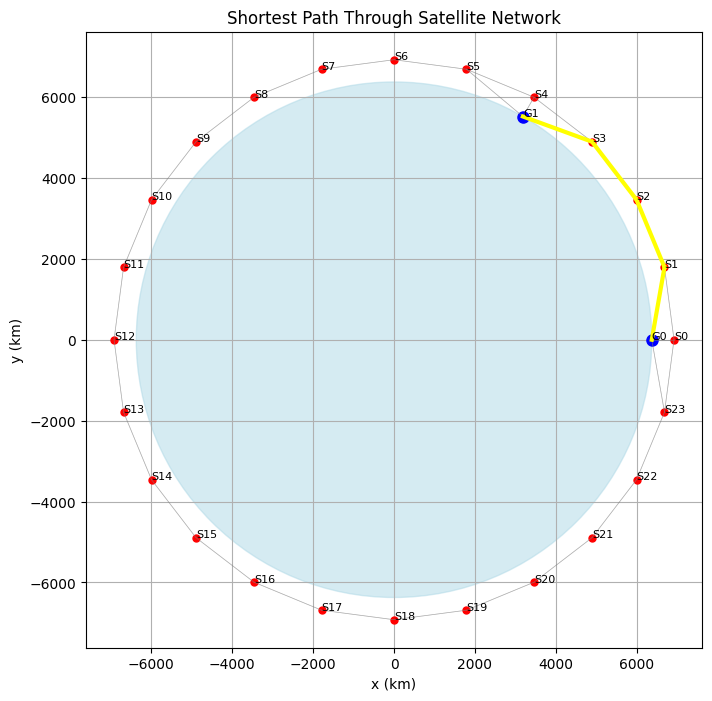

Path found: ['G0', 'S1', 'S2', 'S3', 'G1']
Total delay: 0.0441859 s


In [10]:
# Quick integration test
# ----------------------
# Run the simulation now. If your functions are implemented correctly, the
# simulation will find a path between G0 and G1 and print summary metrics.


try:
    # Example run: adjust parameters if needed
    sim = Simulation(num_sats=24, altitude_km=550.0, ground_angles_deg=[0.0, 60.0], max_isl_km=2500.0)
    total_delay, path = sim.shortest_path('G0', 'G1')

    print("Path:", path)
    print("Total delay:", total_delay)

    plot_shortest_path(sim, path)

    if total_delay is None:
        print('No path found: try changing parameters or check your implementations')
    else:
        print('Path found:', path)
        print(f'Total delay: {total_delay:.6g} s')
except NotImplementedError:
    print('shortest_path not implemented yet')

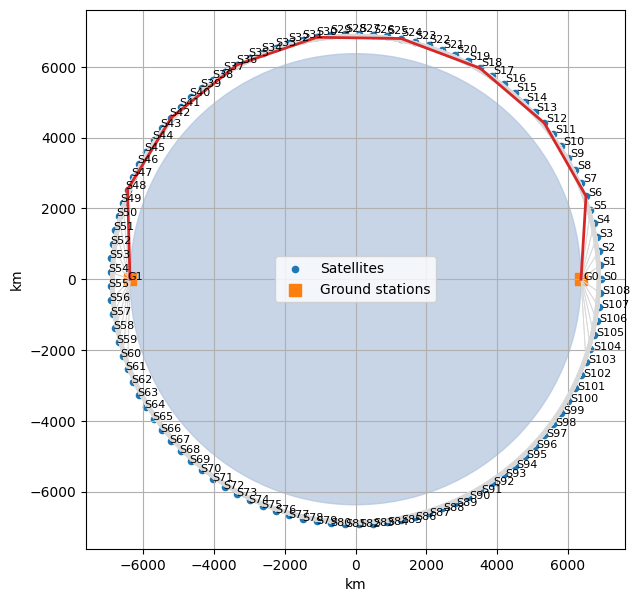

In [ ]:
# Visualisations/animations
# -------------------------
# The plotting helpers below are given to you. Once you implemented the
# functions above and `shortest_path`, the animation will show a signal
# travelling along the computed route. You will not need to modify these cells
# unless you want to make the plot prettier.

def plot_topology(nodes, graph, altitude_km, highlight_path=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    earth = plt.Circle((0, 0), R_EARTH_KM, color='lightsteelblue', alpha=0.7)
    ax.add_patch(earth)

    sats = [n for n in nodes if n.type == 'sat']
    gs = [n for n in nodes if n.type == 'ground']

    ax.scatter([s.pos[0] for s in sats], [s.pos[1] for s in sats], s=20, label='Satellites')
    ax.scatter([g.pos[0] for g in gs], [g.pos[1] for g in gs], s=80, marker='s', color='tab:orange', label='Ground stations')

    for n in nodes:
        ax.text(n.pos[0] * 1.01, n.pos[1] * 1.01, n.id, fontsize=8)

    for a in nodes:
        for b_id, _ in graph[a.id]:
            b = next(n for n in nodes if n.id == b_id)
            ax.plot([a.pos[0], b.pos[0]], [a.pos[1], b.pos[1]], color='0.85', linewidth=0.6)

    if highlight_path is not None and len(highlight_path) > 1:
        for i in range(len(highlight_path) - 1):
            a = next(n for n in nodes if n.id == highlight_path[i])
            b = next(n for n in nodes if n.id == highlight_path[i+1])
            ax.plot([a.pos[0], b.pos[0]], [a.pos[1], b.pos[1]], color='tab:red', linewidth=2.0)

    limit = 1.1 * (R_EARTH_KM + altitude_km)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_xlabel('km')
    ax.set_ylabel('km')
    ax.grid(True)
    ax.legend()
    plt.show()

sim = Simulation(num_sats=109, altitude_km=550.0, ground_angles_deg=[0.0, 180.0], max_isl_km=2500.0)
total_delay, path = sim.shortest_path("G0", "G1")

plot_topology(sim.nodes, sim.graph, sim.altitude_km, highlight_path=path)
#for redunduncy of 5 minimum number satellites is 94 and maximum number of satellites is 109.


In [25]:
def animate_path_slider(sim, path, processing_delay_s=None):
    if processing_delay_s is None:
        processing_delay_s = sim.processing_delay_s
    hops = []
    for i in range(len(path)-1):
        a = next(n for n in sim.nodes if n.id == path[i])
        b = next(n for n in sim.nodes if n.id == path[i+1])
        prop_delay = euclidean_distance(a.pos, b.pos) / C_KM_S
        proc_delay = processing_delay_s if (i < len(path)-1) else 0.0
        hops.append({'from': path[i], 'to': path[i+1], 'prop': prop_delay, 'proc': proc_delay, 'a_pos': a.pos, 'b_pos': b.pos})
    # build time segments
    time_segments = []
    t_cursor = 0.0
    for h in hops:
        time_segments.append(('prop', h['a_pos'], h['b_pos'], t_cursor, t_cursor + h['prop']))
        t_cursor += h['prop']
        if h['proc'] > 0:
            time_segments.append(('proc', h['b_pos'], h['b_pos'], t_cursor, t_cursor + h['proc']))
            t_cursor += h['proc']
    total_time = t_cursor

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.subplots_adjust(bottom=0.15)
    earth = plt.Circle((0, 0), R_EARTH_KM, color='lightsteelblue', alpha=0.7)
    ax.add_patch(earth)
    ax.scatter([n.pos[0] for n in sim.nodes if n.type == 'sat'], [n.pos[1] for n in sim.nodes if n.type == 'sat'], s=20)
    ax.scatter([n.pos[0] for n in sim.nodes if n.type == 'ground'], [n.pos[1] for n in sim.nodes if n.type == 'ground'], s=80, marker='s', color='tab:orange')
    for n in sim.nodes:
        ax.text(n.pos[0] * 1.01, n.pos[1] * 1.01, n.id, fontsize=8)
    for a in sim.nodes:
        for b_id, _ in sim.graph[a.id]:
            b = next(n for n in sim.nodes if n.id == b_id)
            ax.plot([a.pos[0], b.pos[0]], [a.pos[1], b.pos[1]], color='0.85', linewidth=0.6)
    for i in range(len(path)-1):
        a = next(n for n in sim.nodes if n.id == path[i])
        b = next(n for n in sim.nodes if n.id == path[i+1])
        ax.plot([a.pos[0], b.pos[0]], [a.pos[1], b.pos[1]], color='tab:red', linewidth=2.0)
    sig = ax.scatter([], [], s=120, marker='o', color='tab:green', zorder=10)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-1.1 * (R_EARTH_KM + sim.altitude_km), 1.1 * (R_EARTH_KM + sim.altitude_km))
    ax.set_ylim(-1.1 * (R_EARTH_KM + sim.altitude_km), 1.1 * (R_EARTH_KM + sim.altitude_km))
    ax.grid(True)
    axslider = plt.axes([0.15, 0.05, 0.7, 0.03])
    slider = Slider(axslider, 'Time (s)', 0.0, total_time, valinit=0.0)

    def position_at_time(t: float):
        if t <= 0.0:
            return next(n.pos for n in sim.nodes if n.id == path[0])
        if t >= total_time:
            return next(n.pos for n in sim.nodes if n.id == path[-1])
        for phase, a_pos, b_pos, start, end in time_segments:
            if start <= t < end:
                if phase == 'prop':
                    frac = (t - start) / (end - start) if (end - start) > 0 else 0.0
                    x = a_pos[0] + frac * (b_pos[0] - a_pos[0])
                    y = a_pos[1] + frac * (b_pos[1] - a_pos[1])
                    return (x, y)
                else:
                    return a_pos
        return next(n.pos for n in sim.nodes if n.id == path[-1])

    def update(val):
        t = slider.val
        x, y = position_at_time(t)
        sig.set_offsets([[x, y]])
        fig.canvas.draw_idle()

    slider.on_changed(update)
    update(0.0)
    plt.show()

Shortest path: ['G0', 'S1', 'S2', 'S3', 'G1']
Total delay: 0.044185883651807104


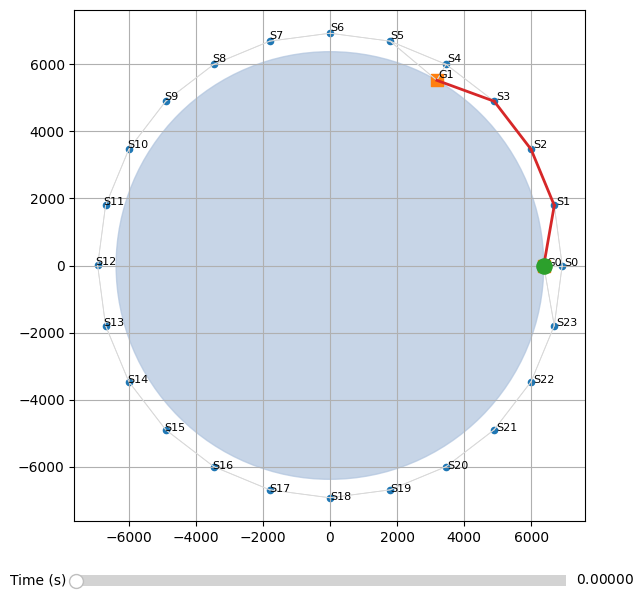

In [31]:
sim = Simulation(num_sats=24, altitude_km=550.0, ground_angles_deg=[0.0, 60.0], max_isl_km=2500.0)
total_delay, path = sim.shortest_path("G0", "G1")

print("Shortest path:", path)
print("Total delay:", total_delay)

animate_path_slider(sim, path)

In [17]:
# What to do next?
# ----------------
# 1. Change `num_sats` to small values (4, 8) and hand-track the shortest path
#    to check your Dijkstra implementation by hand. Write a short note about any
#    differences you see.
# 2. Make a plot of total delay as a function of altitude, keeping num_sats fixed.
# 3. Replace the ring constellation with two co-planar rings offset by half a
#    satellite spacing. Compare resilience qualitatively.
# 4. Add a simple link-budget filter: assume a transmit power, antenna gains and
#    a SNR threshold, and accept edges only when SNR is sufficient. Start with
#    basic Friis equation from the syllabus.

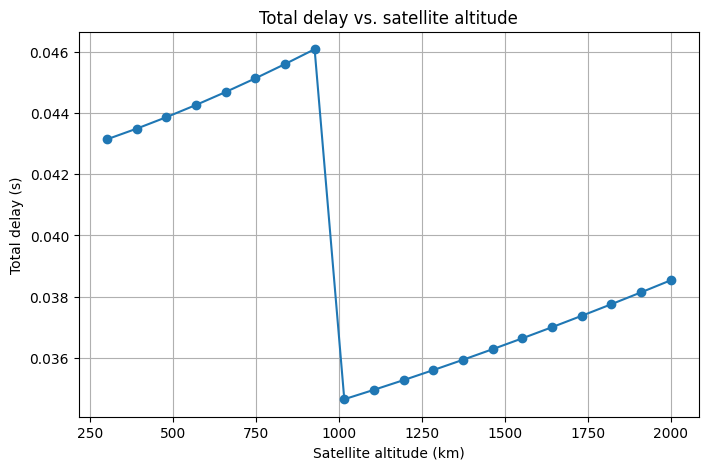

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

altitudes = np.linspace(300, 2000, 20)
delays = []

for alt in altitudes:
    sim = Simulation(
        num_sats=24,
        altitude_km=alt,
        ground_angles_deg=[0.0, 60.0],
        max_isl_km=2500.0
    )
    
    total_delay, path = sim.shortest_path("G0", "G1")
    
    if total_delay is None:
        delays.append(np.nan)  
    else:
        delays.append(total_delay)


plt.figure(figsize=(8,5))
plt.plot(altitudes, delays, marker='o')
plt.xlabel("Satellite altitude (km)")
plt.ylabel("Total delay (s)")
plt.title("Total delay vs. satellite altitude")
plt.grid(True)
plt.show()


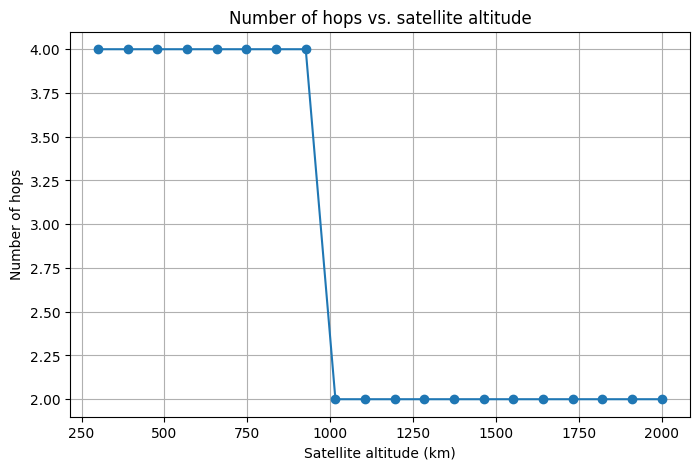

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

altitudes = np.linspace(300, 2000, 20)   
hops = []                                # number of hops for each altitude

for alt in altitudes:
    sim = Simulation(
        num_sats=24,
        altitude_km=alt,
        ground_angles_deg=[0.0, 60.0],
        max_isl_km=2500.0
    )
    
    total_delay, path = sim.shortest_path("G0", "G1")
    
    if path == [] or path is None:
        hops.append(np.nan)   
    else:
        hops.append(len(path) - 1)   # number of hops = edges = nodes - 1


plt.figure(figsize=(8,5))
plt.plot(altitudes, hops, marker='o')
plt.xlabel("Satellite altitude (km)")
plt.ylabel("Number of hops")
plt.title("Number of hops vs. satellite altitude")
plt.grid(True)
plt.show()


In [ ]:
def build_visibility_graph(self):
    graph = {n.id: [] for n in self.nodes}

    #Link budget constants
    k = 1.380649e-23          # Boltzmann constant
    T = 290                   # noise temperature (K)
    Pt = 5.0                  # transmit power (W)
    Gt = 3000.0               # ~35 dBi
    Gr = 3000.0               # ~35 dBi
    B  = 20e6                 # bandwidth (Hz)
    SNR_min = 1.0             # 0 dB threshold
    wavelength = (C_KM_S*1000) / 12e9   # 12 GHz carrier

    for a in self.nodes:
        for b in self.nodes:
            if a.id == b.id:
                continue
            if a.type == "ground" and b.type == "ground":
                continue

            
            if not line_of_sight(a.pos, b.pos):
                continue

            
            d_km = euclidean_distance(a.pos, b.pos)
            d_m  = d_km * 1000.0

            # ISL limit
            if a.type == "sat" and b.type == "sat" and self.max_isl_km is not None:
                if d_km > self.max_isl_km:
                    continue

            #Friis received power
            Pr = Pt * Gt * Gr * (wavelength / (4*math.pi*d_m))**2

            
            N = k * T * B

            # SNR
            SNR = Pr / N

            # SNR filter
            if SNR < SNR_min:
                continue

          
            delay = d_km / C_KM_S + self.processing_delay_s
            graph[a.id].append((b.id, delay))

    self.graph = graph

Simulation.build_visibility_graph = build_visibility_graph


In [72]:
sim = Simulation(num_sats=24, altitude_km=550.0,
                 ground_angles_deg=[0.0, 60.0],
                 max_isl_km=2500.0)

total_delay, path = sim.shortest_path("G0", "G1")
print("Path:", path)
print("Total delay:", total_delay)


Path: ['G0', 'S1', 'S2', 'S3', 'G1']
Total delay: 0.044185883651807104


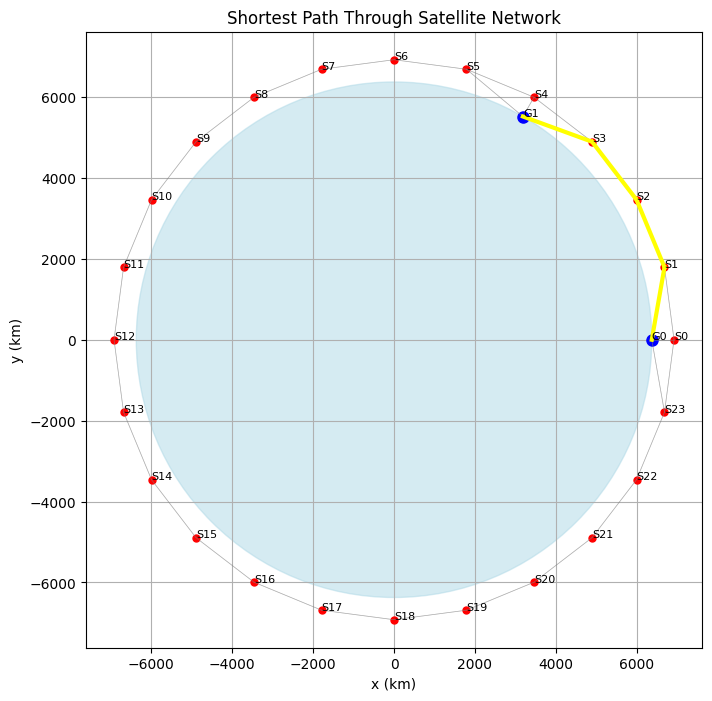

In [73]:
plot_shortest_path(sim, path)
